In [1]:
import json, os
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# To disable false warning
# read from https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.chained_assignment = None

In [2]:
print('Current working directory: ' + os.getcwd())
os.chdir('../downloads')
print('New working directory: ' + os.getcwd())

Current working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\notebooks
New working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\downloads


In [3]:
# db = []
# for f in os.listdir(os.getcwd()+ os.sep + '230821'):
#     file = open(os.getcwd() + os.sep + '230821' + os.sep + f)
#     data = json.load(file)
#     file.close()

In [4]:
date = '230821'

In [5]:
for f in os.listdir(os.getcwd()+ os.sep + date):
    file = open(os.getcwd() + os.sep + date + os.sep + f)
    data = json.load(file)
    file.close()
    break

In [6]:
data.keys()

dict_keys(['match_id', 'barracks_status_dire', 'barracks_status_radiant', 'chat', 'cluster', 'cosmetics', 'dire_score', 'dire_team_id', 'draft_timings', 'duration', 'engine', 'first_blood_time', 'game_mode', 'human_players', 'leagueid', 'lobby_type', 'match_seq_num', 'negative_votes', 'objectives', 'picks_bans', 'positive_votes', 'radiant_gold_adv', 'radiant_score', 'radiant_team_id', 'radiant_win', 'radiant_xp_adv', 'skill', 'start_time', 'teamfights', 'tower_status_dire', 'tower_status_radiant', 'version', 'replay_salt', 'series_id', 'series_type', 'players', 'patch', 'region', 'replay_url'])

In [7]:


def convert_seconds(time):
    ''''
    Converts time from integer to Hour:Minutes:Seconds format
    time: integer representation of time in seconds
    '''
    h = time//3600
    sec = time%60
    sec = ['0' + str(sec) if sec < 10 else sec][0]
    if h > 0 :
        time = time%3600
        minutes = time//60
        minutes = ['0' + str(minutes) if minutes < 10 else minutes][0]
        return(str(h)+ ':' + str(minutes)+ ':' + str(sec))
    else:
        return(str(time//60)+ ':' + str(sec))

In [8]:
convert_seconds(3900)

'1:05:00'

In [9]:
convert_seconds(data['duration']), convert_seconds(data['first_blood_time'])

('31:59', '2:28')

# Can consider following dimensions
## Pre Game
- patch 49 -> 7.30
- match_id
- game_mode, human_players, skill, region

## During Game
- picks_ban # A list of dictionaries containing a boolean relating to whether the choice is a pick or a ban, the hero ID, the team the picked or banned it, and the order.
- fb time

## End game
- radiant_win #True -> Radiant, False -> Dire
- Duration
- barracks_status_dire, barracks_status_radiant
- dire_score, Radiant_score #integer signifying the number of kills




In [10]:
db = []
for f in os.listdir(os.getcwd()+ os.sep + '230821'):
    file = open(os.getcwd() + os.sep + '230821' + os.sep + f)
    data = json.load(file)
    file.close()
    
    #ignoring errors by skipping
    if "error" in data.keys():
        continue
    # skip those with bots
    if data["human_players"] != 10:
        continue
    #skip those with no pick data
    if not data["picks_bans"]:
        continue
    
    #radiant = team 0
    win_team = 0
    if data["radiant_win"] == False:
        win_team = 1
    
    # get pick info
    picks = pd.DataFrame(data['picks_bans'])
    picks = picks[picks.is_pick] # drop bans
    picks = picks.sort_values('order')

    #adding last 2 picks to database
    db.append([data['match_id'],
              picks.iloc[-1].hero_id,
              picks.iloc[-1].team == win_team])
    
    db.append([data['match_id'],
              picks.iloc[-2].hero_id,
              picks.iloc[-2].team == win_team])
db = pd.DataFrame(db, columns = ['match_id','hero_id','win'])
    
# keep heroes >= 50
count = db.hero_id.value_counts()
keep = count[count > 50].index
db = db[db.hero_id.isin(keep)]

#getting winrate
winrate = db.groupby('hero_id')['win'].mean()
winrate = winrate.sort_values()

# changing hero id to name

heroes = pd.read_csv('./hero_data/hero_stats_23August2021.csv')[['name','hero_id']] #only want the name and hero_id column
lookup = {k:v[14:] for k,v in zip(heroes.hero_id, heroes.name)}

def convert2name(id):
    return[lookup[i] for i in id]
    
    

In [11]:
heroes_data = pd.read_csv('./hero_data/hero_stats_23August2021.csv')
heroes_data.columns

Index(['Unnamed: 0', 'id', 'name', 'localized_name', 'primary_attr',
       'attack_type', 'roles', 'img', 'icon', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_mr', 'base_attack_min', 'base_attack_max', 'base_str', 'base_agi',
       'base_int', 'str_gain', 'agi_gain', 'int_gain', 'attack_range',
       'projectile_speed', 'attack_rate', 'move_speed', 'turn_rate',
       'cm_enabled', 'legs', 'hero_id', 'turbo_picks', 'turbo_wins', 'pro_win',
       'pro_pick', 'pro_ban', '1_pick', '1_win', '2_pick', '2_win', '3_pick',
       '3_win', '4_pick', '4_win', '5_pick', '5_win', '6_pick', '6_win',
       '7_pick', '7_win', '8_pick', '8_win', 'null_pick', 'null_win'],
      dtype='object')

In [12]:
heroes_df = heroes_data[['hero_id', 'localized_name', 
                        'base_health','base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
                        'base_attack_min', 'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain','primary_attr']]

In [13]:
# heroes_df = heroes_df.set_index(['hero_id']).reset_index()
# heroes_df


In [14]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name].copy() - min_value) / (max_value - min_value)
    return result

In [15]:
# health, armor, mana, hp regen, mana regen, 'base_attack_min'

In [16]:
def calculate_starting_stats(base_stats, base_attribute, additional_values=0,decimal=0):
    '''
    
    '''

    start_stats = base_stats + (base_attribute*additional_values)
    #Round off the value
    if decimal != 0:
        return round(start_stats,decimal)
    else:
        return round(start_stats)

In [17]:
heroes_df['base_primary_attr'] = heroes_df.loc[:,'primary_attr'].apply(lambda row: 'base_' + row)

In [18]:
heroes_df['health']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_health'],row['base_str'],20), axis=1)
heroes_df['armor']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_armor'],row['base_agi'],(1/6)), axis=1)
heroes_df['health_regen']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_health_regen'],row['base_str'],(0.1),1), axis=1)
heroes_df['mana']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_mana'],row['base_str'],12), axis=1)
heroes_df['mana_regen']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_mana_regen'],row['base_str'],0.05,1), axis=1)
i = heroes_df.columns.get_indexer(heroes_df['base_primary_attr'])
heroes_df['attack_min'] = heroes_df['base_attack_min'] + heroes_df.values[heroes_df.index, i]
# heroes_df['attack_min']=heroes_df.apply(lambda row: calculate_starting_stats(row['base_attack_min'],row['base_str']), axis=1)


In [19]:
heroes_df = heroes_df.loc[:,('hero_id', 'localized_name', 
                        'health','health_regen', 'mana', 'mana_regen', 'armor',
                        'attack_min', 'base_str', 'base_agi','base_int',
                        'str_gain', 'agi_gain', 'int_gain')]

In [20]:
heroes_df.head(5)

,hero_id,localized_name,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
0,1,Anti-Mage,660,2.6,351,1.2,4,53,23,24,12,1.6,2.8,1.8
1,2,Axe,700,5.2,375,1.2,2,52,25,20,18,3.4,2.2,1.6
2,3,Bane,640,2.5,339,1.1,5,57,22,22,22,2.6,2.6,2.6
3,4,Bloodseeker,680,2.7,363,1.2,6,57,24,22,17,2.7,3.4,2.0
4,5,Crystal Maiden,560,2.0,291,1.9,2,44,18,16,16,2.2,1.6,3.3


In [21]:
hero_list = heroes_data['localized_name'].tolist()
hero_list

['Anti-Mage',
 'Axe',
 'Bane',
 'Bloodseeker',
 'Crystal Maiden',
 'Drow Ranger',
 'Earthshaker',
 'Juggernaut',
 'Mirana',
 'Morphling',
 'Shadow Fiend',
 'Phantom Lancer',
 'Puck',
 'Pudge',
 'Razor',
 'Sand King',
 'Storm Spirit',
 'Sven',
 'Tiny',
 'Vengeful Spirit',
 'Windranger',
 'Zeus',
 'Kunkka',
 'Lina',
 'Lion',
 'Shadow Shaman',
 'Slardar',
 'Tidehunter',
 'Witch Doctor',
 'Lich',
 'Riki',
 'Enigma',
 'Tinker',
 'Sniper',
 'Necrophos',
 'Warlock',
 'Beastmaster',
 'Queen of Pain',
 'Venomancer',
 'Faceless Void',
 'Wraith King',
 'Death Prophet',
 'Phantom Assassin',
 'Pugna',
 'Templar Assassin',
 'Viper',
 'Luna',
 'Dragon Knight',
 'Dazzle',
 'Clockwerk',
 'Leshrac',
 "Nature's Prophet",
 'Lifestealer',
 'Dark Seer',
 'Clinkz',
 'Omniknight',
 'Enchantress',
 'Huskar',
 'Night Stalker',
 'Broodmother',
 'Bounty Hunter',
 'Weaver',
 'Jakiro',
 'Batrider',
 'Chen',
 'Spectre',
 'Ancient Apparition',
 'Doom',
 'Ursa',
 'Spirit Breaker',
 'Gyrocopter',
 'Alchemist',
 'Invoke

In [22]:
heroes_df.columns

Index(['hero_id', 'localized_name', 'health', 'health_regen', 'mana',
       'mana_regen', 'armor', 'attack_min', 'base_str', 'base_agi', 'base_int',
       'str_gain', 'agi_gain', 'int_gain'],
      dtype='object')

In [23]:
target_cols = ['health','health_regen', 'mana', 'mana_regen', 'armor', 
            'attack_min','base_str', 'base_agi','base_int',
            'str_gain', 'agi_gain', 'int_gain']


In [24]:
heroes_df[target_cols] = heroes_df[target_cols].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
heroes_df

,hero_id,localized_name,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
0,1,Anti-Mage,0.583333,0.189189,0.583333,0.333333,0.444444,0.37037,0.583333,0.705882,0.000000,0.032258,0.636364,0.190476
1,2,Axe,0.750000,0.891892,0.750000,0.333333,0.222222,0.351852,0.750000,0.588235,0.333333,0.612903,0.500000,0.142857
2,3,Bane,0.500000,0.162162,0.500000,0.250000,0.555556,0.444444,0.500000,0.647059,0.555556,0.354839,0.590909,0.380952
3,4,Bloodseeker,0.666667,0.216216,0.666667,0.333333,0.666667,0.444444,0.666667,0.647059,0.277778,0.387097,0.772727,0.238095
4,5,Crystal Maiden,0.166667,0.027027,0.166667,0.916667,0.222222,0.203704,0.166667,0.470588,0.222222,0.225806,0.363636,0.547619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,123,Hoodwink,0.083333,0.027027,0.083333,0.083333,0.444444,0.240741,0.083333,0.705882,0.500000,0.161290,0.818182,0.452381
117,126,Void Spirit,0.500000,0.162162,0.500000,0.750000,0.222222,0.388889,0.500000,0.558824,0.666667,0.354839,0.500000,0.500000
118,128,Snapfire,0.333333,0.081081,0.333333,0.166667,0.444444,0.240741,0.333333,0.470588,0.500000,0.645161,0.431818,0.285714
119,129,Mars,0.583333,0.189189,0.583333,0.750000,0.222222,0.351852,0.583333,0.588235,0.500000,0.612903,0.386364,0.285714


In [25]:
heroes_df = heroes_df.fillna(0)
heroes_df

,hero_id,localized_name,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
0,1,Anti-Mage,0.583333,0.189189,0.583333,0.333333,0.444444,0.370370,0.583333,0.705882,0.000000,0.032258,0.636364,0.190476
1,2,Axe,0.750000,0.891892,0.750000,0.333333,0.222222,0.351852,0.750000,0.588235,0.333333,0.612903,0.500000,0.142857
2,3,Bane,0.500000,0.162162,0.500000,0.250000,0.555556,0.444444,0.500000,0.647059,0.555556,0.354839,0.590909,0.380952
3,4,Bloodseeker,0.666667,0.216216,0.666667,0.333333,0.666667,0.444444,0.666667,0.647059,0.277778,0.387097,0.772727,0.238095
4,5,Crystal Maiden,0.166667,0.027027,0.166667,0.916667,0.222222,0.203704,0.166667,0.470588,0.222222,0.225806,0.363636,0.547619
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,123,Hoodwink,0.083333,0.027027,0.083333,0.083333,0.444444,0.240741,0.083333,0.705882,0.500000,0.161290,0.818182,0.452381
117,126,Void Spirit,0.500000,0.162162,0.500000,0.750000,0.222222,0.388889,0.500000,0.558824,0.666667,0.354839,0.500000,0.500000
118,128,Snapfire,0.333333,0.081081,0.333333,0.166667,0.444444,0.240741,0.333333,0.470588,0.500000,0.645161,0.431818,0.285714
119,129,Mars,0.583333,0.189189,0.583333,0.750000,0.222222,0.351852,0.583333,0.588235,0.500000,0.612903,0.386364,0.285714


In [26]:
heroes_df.loc[80]

hero_id                 82
localized_name       Meepo
health            0.666667
health_regen      0.216216
mana              0.666667
mana_regen        0.333333
armor             0.777778
attack_min        0.240741
base_str          0.666667
base_agi               0.5
base_int          0.444444
str_gain          0.032258
agi_gain          0.363636
int_gain          0.142857
Name: 80, dtype: object

In [27]:
hero_id = 76
heroes_df[heroes_df['hero_id']==hero_id]['localized_name'].values

array(['Outworld Devourer'], dtype=object)

In [28]:
heroes_df[heroes_df['hero_id']==hero_id]

,hero_id,localized_name,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
74,76,Outworld Devourer,0.416667,0.324324,0.416667,0.25,0.666667,0.296296,0.416667,0.647059,1.0,0.451613,0.363636,0.761905


In [29]:
heroes_df.loc[heroes_df['hero_id']==hero_id][target_cols]

,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
74,0.416667,0.324324,0.416667,0.25,0.666667,0.296296,0.416667,0.647059,1.0,0.451613,0.363636,0.761905


In [30]:
hero_list = heroes_data['localized_name'].tolist()
hero_list

['Anti-Mage',
 'Axe',
 'Bane',
 'Bloodseeker',
 'Crystal Maiden',
 'Drow Ranger',
 'Earthshaker',
 'Juggernaut',
 'Mirana',
 'Morphling',
 'Shadow Fiend',
 'Phantom Lancer',
 'Puck',
 'Pudge',
 'Razor',
 'Sand King',
 'Storm Spirit',
 'Sven',
 'Tiny',
 'Vengeful Spirit',
 'Windranger',
 'Zeus',
 'Kunkka',
 'Lina',
 'Lion',
 'Shadow Shaman',
 'Slardar',
 'Tidehunter',
 'Witch Doctor',
 'Lich',
 'Riki',
 'Enigma',
 'Tinker',
 'Sniper',
 'Necrophos',
 'Warlock',
 'Beastmaster',
 'Queen of Pain',
 'Venomancer',
 'Faceless Void',
 'Wraith King',
 'Death Prophet',
 'Phantom Assassin',
 'Pugna',
 'Templar Assassin',
 'Viper',
 'Luna',
 'Dragon Knight',
 'Dazzle',
 'Clockwerk',
 'Leshrac',
 "Nature's Prophet",
 'Lifestealer',
 'Dark Seer',
 'Clinkz',
 'Omniknight',
 'Enchantress',
 'Huskar',
 'Night Stalker',
 'Broodmother',
 'Bounty Hunter',
 'Weaver',
 'Jakiro',
 'Batrider',
 'Chen',
 'Spectre',
 'Ancient Apparition',
 'Doom',
 'Ursa',
 'Spirit Breaker',
 'Gyrocopter',
 'Alchemist',
 'Invoke

In [31]:
heroes_df = heroes_df.set_index('localized_name')
heroes_df.head(5)

,hero_id,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
localized_name,,,,,,,,,,,,,
Anti-Mage,1,0.583333,0.189189,0.583333,0.333333,0.444444,0.370370,0.583333,0.705882,0.000000,0.032258,0.636364,0.190476
Axe,2,0.750000,0.891892,0.750000,0.333333,0.222222,0.351852,0.750000,0.588235,0.333333,0.612903,0.500000,0.142857
Bane,3,0.500000,0.162162,0.500000,0.250000,0.555556,0.444444,0.500000,0.647059,0.555556,0.354839,0.590909,0.380952
Bloodseeker,4,0.666667,0.216216,0.666667,0.333333,0.666667,0.444444,0.666667,0.647059,0.277778,0.387097,0.772727,0.238095
Crystal Maiden,5,0.166667,0.027027,0.166667,0.916667,0.222222,0.203704,0.166667,0.470588,0.222222,0.225806,0.363636,0.547619


In [32]:
heroes_df = heroes_df.iloc[:,1:]
heroes_df.head(5)

,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
localized_name,,,,,,,,,,,,
Anti-Mage,0.583333,0.189189,0.583333,0.333333,0.444444,0.370370,0.583333,0.705882,0.000000,0.032258,0.636364,0.190476
Axe,0.750000,0.891892,0.750000,0.333333,0.222222,0.351852,0.750000,0.588235,0.333333,0.612903,0.500000,0.142857
Bane,0.500000,0.162162,0.500000,0.250000,0.555556,0.444444,0.500000,0.647059,0.555556,0.354839,0.590909,0.380952
Bloodseeker,0.666667,0.216216,0.666667,0.333333,0.666667,0.444444,0.666667,0.647059,0.277778,0.387097,0.772727,0.238095
Crystal Maiden,0.166667,0.027027,0.166667,0.916667,0.222222,0.203704,0.166667,0.470588,0.222222,0.225806,0.363636,0.547619


In [33]:
selected_hero = hero_list[0]

In [34]:
heroes_df.loc[selected_hero]

health          0.583333
health_regen    0.189189
mana            0.583333
mana_regen      0.333333
armor           0.444444
attack_min      0.370370
base_str        0.583333
base_agi        0.705882
base_int        0.000000
str_gain        0.032258
agi_gain        0.636364
int_gain        0.190476
Name: Anti-Mage, dtype: float64

# Graphs

In [35]:
print('Current working directory: ' + os.getcwd())
os.chdir('../dashboard')
print('New working directory: ' + os.getcwd())

Current working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\downloads
New working directory: c:\Users\Boonchong\Desktop\defense_of_the_ancient\dashboard


In [36]:
from common_functions import *
from charts import*

In [37]:
df = pd.read_csv('../downloads/hero_data/hero_stats_23August2021.csv')
hero_list, df = preprocess_df(df)

In [38]:
selected_hero=hero_list[2]

In [44]:
def radar_hero_trace(fig,df,selected_hero):
    fig.add_trace(
    go.Scatterpolar(
        r=list(df.loc[selected_hero]),
        theta=df.columns,
        mode='markers+lines',
        text=list(selected_hero),
        textposition="top center",
        textfont_size=15,
        fill="toself",
        fillcolor="#008FD3",
        line=dict(color="#F0AB00"),
        marker=dict(color="#AB7A00",size=5),
        opacity=0.5,
        name=selected_hero
        )
    )

In [42]:
def get_radar_heroes(selected_hero,df):
    fig = go.Figure()
    radar_hero_trace(fig,df,selected_hero)
    fig.update_traces(hovertemplate='%{theta}' + '<br>Value:%{r:.2f}</br>', selector=dict(type='scatterpolar'))
    fig.update_layout(title=dict(text=selected_hero,x=0.5,y=0.95))
    return fig

In [39]:
get_radar_heroes(selected_hero,heroes_df)

In [40]:
fig = go.Figure()
fig.add_trace(
    go.Scatterpolar(
        r=list(heroes_df.loc[selected_hero]),
        theta=target_cols,
        mode='markers+lines',
        text=list(selected_hero),
        textposition="top center",
        textfont_size=15,
        fill="toself",
        fillcolor="#008FD3",
        line=dict(color="#F0AB00"),
        marker=dict(color="#AB7A00",size=5),
        opacity=0.5,
        name=selected_hero
    )
)
fig.update_traces(hovertemplate='%{theta}' + '<br>Value:%{r:.2f}</br>', selector=dict(type='scatterpolar'))
fig.update_layout(title=dict(text=selected_hero,x=0.5,y=0.95))
fig

In [32]:
heroes_data.sort_values(by=['base_int'], ascending=False)[['localized_name','base_int']].head(5)

,localized_name,base_int
32,Tinker,30
74,Outworld Devourer,30
23,Lina,30
83,Undying,27
110,Winter Wyvern,26


In [33]:
heroes_df.sort_values(by=['base_int'], ascending=False)

,hero_id,localized_name,health,health_regen,mana,mana_regen,armor,attack_min,base_str,base_agi,base_int,str_gain,agi_gain,int_gain
32,34,Tinker,0.166667,0.027027,0.166667,0.666667,0.444444,0.388889,0.166667,0.382353,1.000000,0.322581,0.272727,0.547619
74,76,Outworld Devourer,0.416667,0.324324,0.416667,0.250000,0.666667,0.296296,0.416667,0.647059,1.000000,0.451613,0.363636,0.761905
23,25,Lina,0.333333,0.081081,0.333333,0.166667,0.444444,0.333333,0.333333,0.676471,1.000000,0.290323,0.477273,0.642857
83,85,Undying,0.500000,0.162162,0.500000,0.250000,0.333333,0.444444,0.500000,0.294118,0.833333,0.419355,0.272727,0.428571
110,112,Winter Wyvern,0.666667,0.216216,0.666667,0.333333,0.333333,0.129630,0.666667,0.470588,0.777778,0.354839,0.386364,0.619048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,71,Spirit Breaker,0.916667,0.567568,0.916667,0.500000,0.555556,0.462963,0.916667,0.500000,0.111111,0.483871,0.386364,0.190476
30,32,Riki,0.166667,0.648649,0.166667,0.083333,0.666667,0.481481,0.166667,0.529412,0.111111,0.290323,0.318182,0.071429
78,80,Lone Druid,0.166667,0.027027,0.166667,0.083333,0.111111,0.092593,0.166667,0.588235,0.055556,0.322581,0.636364,0.095238
93,95,Troll Warlord,0.416667,0.135135,0.416667,0.250000,0.222222,0.277778,0.416667,0.617647,0.055556,0.322581,0.750000,0.000000


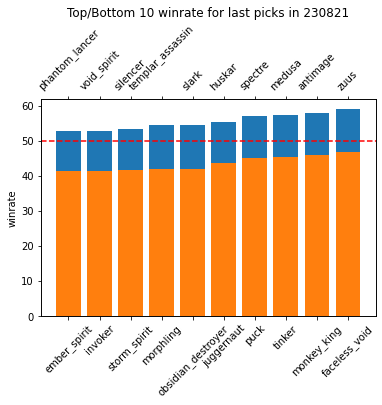

In [34]:
N = 10
tail10 = winrate.iloc[:N]
head10 = winrate.iloc[-N:]

fig, ax1 = plt.subplots()
ax2 = ax1.twiny()

ax1.bar(range(N), 100 * head10.values)
ax1.bar(range(N), 100 * tail10.values)

ax1.set_xticks(range(N))
ax1.set_xticklabels(convert2name(tail10.index))
ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(range(N))
ax2.set_xticklabels(convert2name(head10.index))
ax1.tick_params(axis='x', rotation=45)
ax2.tick_params(axis='x', rotation=45)
ax1.set_ylabel('winrate')

ax1.set_title('Top/Bottom 10 winrate for last picks in 230821')
ax1.axhline(y=50, linestyle='--', color='red')
plt.show()

In [35]:
tail10

hero_id
106    0.413793
74     0.414286
17     0.417582
10     0.418182
76     0.418182
8      0.435484
13     0.450980
34     0.454545
114    0.458333
41     0.466667
Name: win, dtype: float64

In [36]:
head10

hero_id
12     0.526316
126    0.528302
75     0.532258
46     0.543210
93     0.544304
59     0.551724
67     0.571429
94     0.573529
1      0.578947
22     0.590164
Name: win, dtype: float64